C:\Users\Davide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Davide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


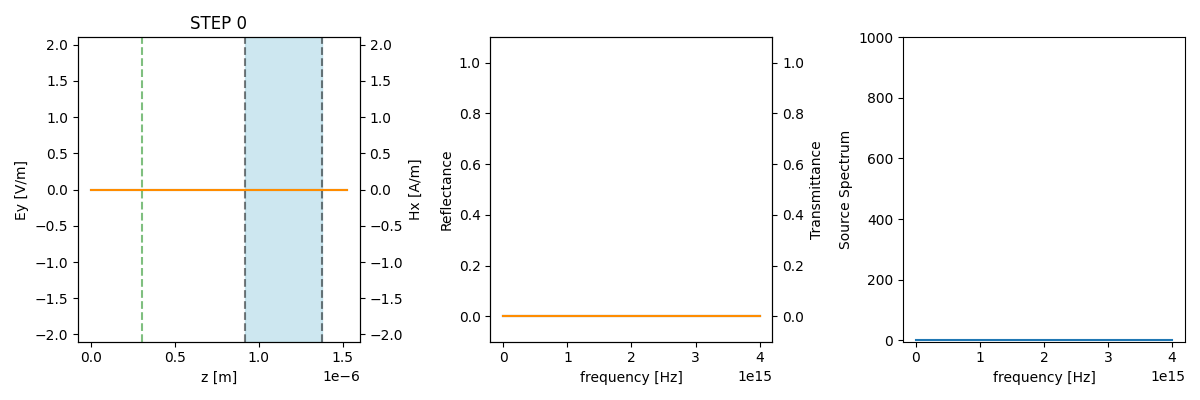

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c
from matplotlib.animation import FuncAnimation

def Gaussian_source(t, f_max, A): 
    tau = 1/(np.pi*f_max)
    t_0 = 6*tau
    y = A*np.exp(-((t-t_0)/tau)**2)
    return y

Nz = 500
N_time_steps = 6000

f_max = 200e13
z_source = 100

#smallest_feature_dimension = 1e-2
eps_yy = np.ones(Nz)
eps_yy_init = 300
eps_yy_fin = 450
eps_yy_material = 6
eps_yy[eps_yy_init:eps_yy_fin] = eps_yy_material*np.ones(eps_yy_fin-eps_yy_init)
mu_xx = np.ones(Nz)

n = np.sqrt(mu_xx*eps_yy)

N_lam = 20
N_dim = 4
lambda_min = c/(f_max*np.max(n))
#z_step = np.min([lambda_min/N_lam, smallest_feature_dimension/N_dim])
z_step = lambda_min/N_lam
z_axis = np.arange(0, z_step*Nz, z_step)

time_step = n[0]*z_step/(2*c)

mEy = c*time_step/(eps_yy*z_step)
mHx = c*time_step/(mu_xx*z_step)

time_array = np.arange(0, time_step*N_time_steps, time_step)
A_e = 1
g_e = Gaussian_source(time_array, f_max, A_e)
A_h = -A_e*np.sqrt(eps_yy[z_source]/mu_xx[z_source])
delta_t = n[z_source]*z_step/(2*c) + time_step/2
g_h = Gaussian_source(time_array + delta_t, f_max, A_h)

Ey = np.zeros(Nz)
Hx = np.zeros(Nz)
H1 = 0
H2 = 0
H3 = 0
E1 = 0
E2 = 0
E3 = 0

n_freq = 1000
frequencies = np.linspace(0, 2*f_max, n_freq)

K = np.exp(-1j*2*np.pi*time_step*frequencies)
reflection_transform = np.zeros(n_freq, dtype= "complex")
transmission_transform = np.zeros(n_freq, dtype= "complex")
source_transform = np.zeros(n_freq, dtype= "complex")
total_transform = np.zeros(n_freq, dtype= "complex")

fig, ax = plt.subplots(ncols=3, figsize = (12,4))

# Create twinx axes
ax1_twin = ax[0].twinx()
ax2_twin = ax[1].twinx()

e_field, = ax[0].plot(z_axis, Ey, label='Ey')
h_field, = ax1_twin.plot(z_axis, Hx, label='Hx', color = "darkorange")
ax[0].axvline(z_axis[z_source], color = "green", alpha = 0.5, linestyle = "--")
ax[0].axvline(z_axis[eps_yy_init], color = "black", alpha = 0.5, linestyle = "--")
ax[0].axvline(z_axis[eps_yy_fin], color = "black", alpha = 0.5, linestyle = "--")
ax[0].axvspan(z_axis[eps_yy_init], z_axis[eps_yy_fin], alpha=0.6, color='lightblue')
title = ax[0].set_title('STEP 0')
ax[0].set_xlabel("z [m]")
ax[0].set_ylabel("Ey [V/m]")
ax1_twin.set_ylabel("Hx [A/m]")

reflection, = ax[1].plot(frequencies, reflection_transform, label='Reflectance')
transmission, = ax2_twin.plot(frequencies, transmission_transform, label='Transmittance', color = "darkorange")
total, = ax[1].plot(frequencies, total_transform, color = "grey")
ax[1].set_xlabel("frequency [Hz]")
ax[1].set_ylabel("Reflectance")
ax2_twin.set_ylabel("Transmittance")

source, = ax[2].plot(frequencies, source_transform)
ax[2].set_xlabel("frequency [Hz]")
ax[2].set_ylabel("Source Spectrum")

Ey0_time = []
Eyf_time = []

def animate(i):
    global Ey, Hx, H3, H2, H1, E3, E2, E1, K, time_step, reflection_transform, transmission_transform, source_transform, total_spectrum, eps_yy, mu_xx, n, z_step, z_source, mHx, mEy, g_e, g_h
    
    Hx[0:Nz-1] = Hx[0:Nz-1] + mHx[0:Nz-1]*(Ey[1:Nz] - Ey[0:Nz-1])
    Hx[Nz-1] = Hx[Nz-1] + mHx[Nz-1]*(E3 - Ey[Nz-1])
    
    Hx[z_source-1] = Hx[z_source-1] - mHx[z_source-1]*g_e[i]
    #Hx[z_source-1] += g_h[i]
    H3 = H2
    H2 = H1
    H1 = Hx[0]

    Ey[0] = Ey[0] + mEy[0]*(Hx[0] - H3)
    Ey[1:Nz] = Ey[1:Nz] + mEy[1:Nz]*(Hx[1:Nz] - Hx[0:Nz-1])
    Ey[z_source] = Ey[z_source] - mEy[z_source]*g_h[i]
    #Ey[z_source] += g_e[i]

    E3 = E2
    E2 = E1
    E1 = Ey[Nz-1]

    Ey0_time.append(Ey[z_source-1])
    Eyf_time.append(Ey[-1])

    e_field.set_ydata(Ey)
    h_field.set_ydata(Hx)

    source_transform += time_step*(K**i)*g_e[i]
    reflection_transform += time_step*(K**i)*Ey[0]
    transmission_transform += time_step*(K**i)*Ey[Nz-1]

    source_spectrum = np.abs(source_transform)**2
    reflection_spectrum = np.abs(reflection_transform/source_transform)**2
    transmission_spectrum = np.abs(transmission_transform/source_transform)**2
    total_spectrum = reflection_spectrum + transmission_spectrum
    
    transmission.set_ydata(transmission_spectrum)
    reflection.set_ydata(reflection_spectrum)
    total.set_ydata(total_spectrum)

    source.set_ydata(source_spectrum/time_step**2)
    title.set_text(f'STEP {i+1} OF {N_time_steps}')
    return e_field, h_field, transmission, reflection, source, total

ani = FuncAnimation(fig, animate, frames=N_time_steps, interval=10, blit=True, repeat=False)

ax[0].set_ylim([-2.1, 2.1])
ax1_twin.set_ylim([-2.1, 2.1])
ax[1].set_ylim([-0.1, 1.1])
ax2_twin.set_ylim([-0.1, 1.1])
ax[2].set_ylim([-5, 1000])
plt.tight_layout()
plt.show()

In [ ]:
plt.close("all")